<a href="https://colab.research.google.com/github/sidgun8/MSME-Credit-Policy-Analysis/blob/main/CAF_script_Srinivasan_Siddharth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# Loading the files for analysis

data=pd.read_csv('/content/fundamentals_dat.txt',delimiter='|')    # data is fundementals_data
df = pd.read_csv('/content/fundamentals_map.txt', delimiter = '|')  # df is the map of fundementals data

In [ ]:
identity_data=pd.read_csv('/content/identity_dat.txt', delimiter = '|')
related_data = pd.read_csv('/content/related_party_dat.txt',delimiter = '|')
related_data_map = pd.read_csv('/content/related_party_map.txt',delimiter = '|')

In [ ]:
# Converting the Date of the column to an easier format to comprehend

data['sa_finance1_year'].astype(str)
data['sa_finance1_year'] = pd.to_datetime(data['sa_finance1_year'], format='%Y%m%d')
data['sa_finance1_year'] = data['sa_finance1_year'].dt.strftime('%Y-%m-%d')
data['sa_finance1_year'] = pd.to_datetime(data['sa_finance1_year'])
data['sa_finance1_year']

,sa_finance1_year
0,2014-03-31
1,2015-03-31
2,2016-03-31
3,2017-03-31
4,2018-03-31
...,...
314527,2019-03-31
314528,2020-03-31
314529,2021-03-31
314530,2022-03-31


In [ ]:
# Converting the Date of the column to an easier format to comprehend

related_data['rpt_date'].astype(str)
related_data['rpt_date'] = pd.to_datetime(related_data['rpt_date'], format='%Y%m%d')
related_data['rpt_date'] = related_data['rpt_date'].dt.strftime('%Y-%m-%d')
related_data['rpt_date'] = pd.to_datetime(related_data['rpt_date'])
related_data['rpt_date']

,rpt_date
0,2014-03-31
1,2014-03-31
2,2014-03-31
3,2014-03-31
4,2014-03-31
...,...
1009211,2022-03-31
1009212,2022-03-31
1009213,2022-03-31
1009214,2022-03-31


In [ ]:
# Making a new column with only the year for easier time series oriented q's coming from the column sa_finance1_year

data['Year'] = pd.to_datetime(data['sa_finance1_year']).dt.year
data['Year'] = data['sa_finance1_year'].astype(str).str[:4].astype(int)

In [ ]:
# Q1 Checking if the rows have any duplicates at the firm-year level
# Going by all the rows ensuring that the combination of firm and year of report are unique


duplicates = data.duplicated(subset=['sa_company_name', 'sa_finance1_year'], keep=False)
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows at the firm-year level (fundemental data): {num_duplicates}")



#  the same for identity and related data as well

duplicates_identity_data = identity_data.duplicated(subset=['company_name', 'incorporation_year'], keep=False)
num_duplicates = duplicates_identity_data.sum()
print(f"Number of duplicate rows at the firm-year level(identity data): {num_duplicates}")


duplicates_related_data = related_data.duplicated(subset=['company_name', 'rpt_date'], keep=False)
num_duplicates = duplicates_identity_data.sum()
print(f"Number of duplicate rows at the firm-year level(related data): {num_duplicates}")




Number of duplicate rows at the firm-year level (fundemental data): 0
Number of duplicate rows at the firm-year level(identity data): 0
Number of duplicate rows at the firm-year level(related data): 0


In [ ]:
## Question 2, the details and stats of sales, assets and liabilities
pd.options.display.float_format = '{:,.2f}'.format
data[['sa_non_current_liabilities','sa_sales', 'sa_total_assets', 'sa_compensation_to_employees']].describe()

,sa_non_current_liabilities,sa_sales,sa_total_assets,sa_compensation_to_employees
count,"245,965.00","234,660.00","311,959.00","254,085.00"
mean,"2,596.91","5,636.76","13,399.94",561.52
std,"30,852.05","63,346.79","282,889.29","6,655.80"
min,"-14,705.50",-739.60,-0.10,-18.40
25%,9.00,55.40,73.00,4.30
50%,64.10,445.80,422.00,29.20
75%,371.70,"2,134.50","2,059.45",153.20
max,"2,502,220.00","9,530,733.20","55,280,445.60","962,180.00"


In [ ]:
# Question 3 merging fundementals and identity data

# First we rename so that both the primary key names match as we can inner join them
identity_data.rename(columns={'co_code':'sa_finance1_cocode'}, inplace=True)

# Merging the twp datasets
fundementals_identity = pd.merge(identity_data, data, on='sa_finance1_cocode', how='inner')

# Removing all the firms that arent listed on the stock exchange
fundementals_identity = fundementals_identity[fundementals_identity['listed_on_bse_nse'] != 'N']

# Saving the Dataset as asked

fundementals_identity.to_csv('fundementals_identity.csv', index=False)


In [ ]:
# Q 4

# Extracting the 2 Digit Code from the NIC Code
fundementals_identity['nic_prod_code_First_2_digits'] = fundementals_identity['nic_prod_code'].astype(int).astype(str).str[:2].astype(int)

# The Year wise industry sales according two the 2 digits nic code
year_wise_industry_sales = fundementals_identity.groupby(['Year', 'nic_prod_code_First_2_digits'])['sa_sales'].sum().reset_index()

# Sorting the values according to year and industry to study growth
year_wise_industry_sales = year_wise_industry_sales.sort_values(by=['nic_prod_code_First_2_digits', 'Year'])

# Finding out the growth between each year
year_wise_industry_sales['Sales_Growth']=year_wise_industry_sales.groupby('nic_prod_code_First_2_digits')['sa_sales'].diff()

# Finding the number of instances of negative growth
negative_growth = year_wise_industry_sales[year_wise_industry_sales['Sales_Growth'] < 0]

# number of industry-year trends where sales were negative
negative_sales_trends = negative_growth.shape[0]
print(negative_sales_trends)


182


In [ ]:
# Verifying if the numbers are tallying

positive_growth = year_wise_industry_sales[year_wise_industry_sales['Sales_Growth'] > 0]
positive_growth = positive_growth.shape[0]
print(positive_growth + negative_sales_trends)
year_wise_industry_sales['Sales_Growth'].isna().sum()




633


67

In [ ]:
fundementals_identity

,sa_finance1_cocode,company_name,cin_code,state_code,owner_code,owner_gp_name,nic_prod_code,nic_name,incorporation_year,listed_on_bse_nse,...,sa_total_capital.1,sa_curr_liab_n_prov.1,sa_total_assets,sa_non_current_assets,sa_net_plant,sa_current_assets_incl_st_invest_loans,sa_total_assets.1,sa_net_plant.1,Year,nic_prod_code_First_2_digits
9,11,20 MICRONS LTD.,L99999GJ1987PLC009768,4.00,20101037799,20 Microns Group,8.00,Other mining and quarrying,"1,987.00",Y,...,169.10,"1,706.40","3,207.70","1,866.60","1,025.20","1,341.10","3,207.70","1,025.20",2014,8
10,11,20 MICRONS LTD.,L99999GJ1987PLC009768,4.00,20101037799,20 Microns Group,8.00,Other mining and quarrying,"1,987.00",Y,...,169.10,"1,591.30","3,289.80","1,784.50","1,010.20","1,505.30","3,289.80","1,010.20",2015,8
11,11,20 MICRONS LTD.,L99999GJ1987PLC009768,4.00,20101037799,20 Microns Group,8.00,Other mining and quarrying,"1,987.00",Y,...,176.40,"1,592.90","3,342.30","1,711.20","1,008.40","1,631.10","3,342.30","1,008.40",2016,8
12,11,20 MICRONS LTD.,L99999GJ1987PLC009768,4.00,20101037799,20 Microns Group,8.00,Other mining and quarrying,"1,987.00",Y,...,176.40,"1,587.20","3,661.40","2,103.50",968.20,"1,557.90","3,661.40",968.20,2017,8
13,11,20 MICRONS LTD.,L99999GJ1987PLC009768,4.00,20101037799,20 Microns Group,8.00,Other mining and quarrying,"1,987.00",Y,...,176.40,"1,638.60","3,808.70","2,129.20",966.60,"1,679.50","3,808.70",966.60,2018,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314195,686180,A M I C FORGING LTD.,U27100WB2007PLC116674,21.00,20102000000,Private (Indian),"25,910.00","Forging, pressing, stamping and roll-forming o...","2,007.00",Y,...,5.00,22.90,63.80,33.10,16.20,30.70,63.80,16.20,2018,25
314196,686180,A M I C FORGING LTD.,U27100WB2007PLC116674,21.00,20102000000,Private (Indian),"25,910.00","Forging, pressing, stamping and roll-forming o...","2,007.00",Y,...,5.50,34.50,83.60,40.70,23.50,42.90,83.60,23.50,2019,25
314197,686180,A M I C FORGING LTD.,U27100WB2007PLC116674,21.00,20102000000,Private (Indian),"25,910.00","Forging, pressing, stamping and roll-forming o...","2,007.00",Y,...,5.90,23.40,88.30,46.90,26.30,41.40,88.30,26.30,2020,25
314198,686180,A M I C FORGING LTD.,U27100WB2007PLC116674,21.00,20102000000,Private (Indian),"25,910.00","Forging, pressing, stamping and roll-forming o...","2,007.00",Y,...,7.10,48.40,163.20,61.30,24.70,101.90,163.20,24.70,2021,25


In [ ]:
identity_data

,sa_finance1_cocode,company_name,cin_code,state_code,owner_code,owner_gp_name,nic_prod_code,nic_name,incorporation_year,listed_on_bse_nse
0,3,'K' STEAMSHIP AGENCIES PVT. LTD.,U63090MH1971PTC015089,11.00,20102000000,Private (Indian),"46,103.00",Activities of commission agents dealing in who...,"1,971.00",N
1,11,20 MICRONS LTD.,L99999GJ1987PLC009768,4.00,20101037799,20 Microns Group,8.00,Other mining and quarrying,"1,987.00",Y
2,12,20TH CENTURY ENGG. LTD.,U31900DL1984PLC018942,55.00,20101037209,SPML Group,"71,100.00",Architectural and engineering activities and r...,"1,984.00",N
3,13,GREENSTONE INVESTMENTS PVT. LTD.,U65990MH1978PTC020803,11.00,20102000000,Private (Indian),"64,300.00","Trusts, funds and other financial vehicles","1,978.00",N
4,14,20TH CENTURY FINANCE CORPN. LTD. [MERGED],U99999MH1979PTC021609,11.00,20102000000,Private (Indian),"64,920.00",Other credit granting,"1,979.00",N
...,...,...,...,...,...,...,...,...,...,...
54812,689229,SHYAM OXIDES PVT. LTD.,U24224GJ2004PTC044468,4.00,20102000000,Private (Indian),"20,119.00",Manufacture of organic and inorganic chemical ...,"2,004.00",N
54813,689230,TIGER ANALYTICS INDIA CONSULTING PVT. LTD.,U74999TN2021FTC146673,18.00,20202000000,Private (Foreign),"63,111.00",Data processing activities including report wr...,"2,021.00",N
54814,689242,DENNEMEYER INDIA PVT. LTD.,U74999KA2020FTC142297,8.00,20202000000,Private (Foreign),"46,909.00",Other non-specialised wholesale trade n.e.c.,"2,020.00",N
54815,689245,FLOWER DEALTRADE PVT. LTD.,U52100WB2010PTC143995,21.00,20102000000,Private (Indian),"46,909.00",Other non-specialised wholesale trade n.e.c.,"2,010.00",N


In [ ]:
# Q 5

# Renaming the column so we could merge them
fundementals_identity.rename(columns={'sa_finance1_year':'rpt_date'}, inplace=True)

# Merging both columns on the composite keys mentioned
fundementals_identity_related = pd.merge(fundementals_identity,related_data, on=['rpt_date','company_name'], how='inner')

# Computing ratio of Related Party Transactions (RPT) income to the total sales for each firm
fundementals_identity_related['rptincome/sales'] = fundementals_identity_related['rpt_income']/fundementals_identity_related['sa_sales']

# Avg of the ratios across all firms in a year
avg_ratios_per_year = fundementals_identity_related.groupby('Year')['rptincome/sales'].mean().reset_index()
avg_ratios_per_year


,Year,rptincome/sales
0,2013,0.07
1,2014,0.23
2,2015,0.45
3,2016,0.35
4,2017,0.34
5,2018,0.37
6,2019,0.51
7,2020,0.57
8,2021,1.48
9,2022,1.10


<ipython-input-20-e5c3c8a2eccc>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


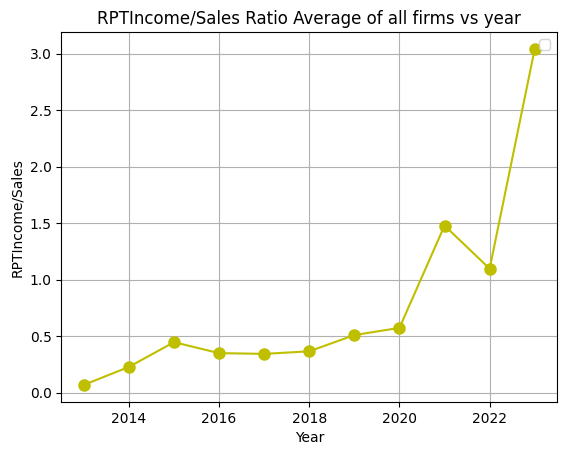

In [ ]:
# The time series graph

plt.plot(avg_ratios_per_year['Year'],avg_ratios_per_year['rptincome/sales'], color='y', linestyle='-', marker='o',markersize=8)
plt.title('RPTIncome/Sales Ratio Average of all firms vs year')
plt.xlabel('Year')
plt.ylabel('RPTIncome/Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Question 6

# Filter for the year 2016
data_2016 = fundementals_identity[fundementals_identity['Year'] == 2016]

# Defining conditions for treatment and control
conditions = [
    (data_2016['sa_net_plant'] >= 50) & (data_2016['sa_net_plant'] <= 100),  # Treatment: Rs. 5-10 crores
    (data_2016['sa_net_plant'] > 100) & (data_2016['sa_net_plant'] <= 150)   # Control: Rs. 10-15 crores
]

# Defining the corresponding values
values = [1, 0]  # 1 = Treatment, 0 = Control

# Creating the 'treatment' column
data_2016['treatment'] = np.select(conditions, values, default=None)


# Appending the column back to the original dataset
fundementals_identity.loc[data_2016.index, 'treatment'] = data_2016['treatment']
fundementals_identity_related.loc[data_2016.index, 'treatment'] = data_2016['treatment']

<ipython-input-21-861718d195ee>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2016['treatment'] = np.select(conditions, values, default=None)


In [ ]:
# Question 7

fundementals_identity_related['post'] = (fundementals_identity_related['Year']>2016).astype(int)

In [ ]:
# Question 8

# Creating the interaction column
fundementals_identity_related['Interaction'] = fundementals_identity_related['treatment'] * fundementals_identity_related['post']



In [ ]:
# To perform regression we make a seprate table to exclude null values

regression_table = fundementals_identity_related.dropna(subset = ['treatment'])
regression_table[['treatment', 'post', 'Interaction']].value_counts()

,,,count
treatment,post,Interaction,
1,1,1,204
0,1,0,153
1,0,0,71
0,0,0,43


In [ ]:
# Question 8.1

# Define dependent and independent variables
X = regression_table[['treatment', 'post','Interaction']]
X = sm.add_constant(X)  # Adds an intercept to the model
y = regression_table['sa_lt_borr_from_banks']

# Ensures all variables are numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#  No Null values are filled its part of the syntax
X = X.fillna(X.mean())
y = y.fillna(y.mean())


# Fit the regression model       Using the Ordinary Least Squares (OLS) to figure if there is any statistical relation or significance, can be further evaluated with better models
model = sm.OLS(y, X).fit()

# Display results
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     sa_lt_borr_from_banks   R-squared:                       0.007
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     1.109
Date:                   Fri, 31 Jan 2025   Prob (F-statistic):              0.345
Time:                           16:10:19   Log-Likelihood:                -4987.5
No. Observations:                    471   AIC:                             9983.
Df Residuals:                        467   BIC:                         1.000e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7259.14

In [ ]:
summary_df = pd.DataFrame({
    "Coefficient": model.params,
    "Standard Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues,
    "Lower 95% CI": model.conf_int()[0],
    "Upper 95% CI": model.conf_int()[1]
})

# Display the DataFrame where P value < 0.05
summary_df[summary_df["P-Value"]<0.05]

,Coefficient,Standard Error,t-Statistic,P-Value,Lower 95% CI,Upper 95% CI
const,"7,259.14","1,471.19",4.93,0.00,"4,368.16","10,150.12"


In [ ]:
X = None
y = None
summary_df = None

In [ ]:
# Question 8.2

# Define dependent and independent variables
X = regression_table[['treatment', 'post','Interaction']]
X['firm'] = regression_table['company_name']
X['industry'] = regression_table['nic_prod_code_First_2_digits']
X['year'] = regression_table['Year']

X = pd.get_dummies(X, columns=['firm', 'industry', 'year'], drop_first=True).astype(int)

y = fundementals_identity_related['sa_lt_borr_from_banks']
y = y[X.index]



# Fit the regression model with firm, industry, and year fixed effects
X = sm.add_constant(X)  # Add constant to the model

# Ensure that all data is numeric and handle any NaNs
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# No Null values are filled its part of the syntax
X = X.fillna(X.mean())
y = y.fillna(y.mean())


# Fit the regression model
model = sm.OLS(y, X).fit()

# Display results
print(model.summary())

<ipython-input-28-06d7b75e2778>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['firm'] = regression_table['company_name']
<ipython-input-28-06d7b75e2778>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['industry'] = regression_table['nic_prod_code_First_2_digits']
<ipython-input-28-06d7b75e2778>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

                              OLS Regression Results                             
Dep. Variable:     sa_lt_borr_from_banks   R-squared:                       0.704
Model:                               OLS   Adj. R-squared:                 -0.130
Method:                    Least Squares   F-statistic:                    0.8437
Date:                   Fri, 31 Jan 2025   Prob (F-statistic):              0.881
Time:                           16:10:20   Log-Likelihood:                -4702.3
No. Observations:                    471   AIC:                         1.010e+04
Df Residuals:                        123   BIC:                         1.155e+04
Df Model:                            347                                         
Covariance Type:               nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [ ]:
# Extract model details into a DataFrame
summary_df = pd.DataFrame({
    "Coefficient": model.params,
    "Standard Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues,
    "Lower 95% CI": model.conf_int()[0],
    "Upper 95% CI": model.conf_int()[1]
})

# Display the DataFrame where P value < 0.05
summary_df[summary_df["P-Value"]<0.05]

,Coefficient,Standard Error,t-Statistic,P-Value,Lower 95% CI,Upper 95% CI
const,"17,811.13","2,448.46",7.27,0.00,"12,964.54","22,657.71"
post,"-12,596.41","2,366.85",-5.32,0.00,"-17,281.45","-7,911.37"
firm_ALOK INDUSTRIES LTD.,"60,245.94","8,466.52",7.12,0.00,"43,486.99","77,004.89"
firm_BAJAJ FINANCE LTD.,"65,912.09","7,538.20",8.74,0.00,"50,990.69","80,833.48"
firm_BHARTI AIRTEL LTD.,"-9,444.99","4,514.44",-2.09,0.04,"-18,381.04",-508.94
firm_BOMBAY DYEING & MFG. CO. LTD.,"17,628.20","7,571.87",2.33,0.02,"2,640.14","32,616.26"
firm_C E S C LTD.,"40,369.59","7,416.82",5.44,0.00,"25,688.45","55,050.73"
firm_TATA STEEL B S L LTD. [MERGED],"57,006.42","9,992.21",5.71,0.00,"37,227.45","76,785.40"
firm_VODAFONE IDEA LTD.,"32,982.96","6,309.96",5.23,0.00,"20,492.78","45,473.15"
industry_24,"6,785.76","3,413.61",1.99,0.05,28.73,"13,542.79"


In [ ]:
y = None
summary_df = None

In [ ]:
y = fundementals_identity_related['sa_st_borr_from_banks']
y = y[X.index]
y.shape

(471,)

In [ ]:
# Question 8.3

# Fit the regression model with firm, industry, and year fixed effects
X = sm.add_constant(X)  # Add constant to the model

# Ensure that all data is numeric and handle any NaNs
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X = X.fillna(X.mean())
y = y.fillna(y.mean())


# Fit the regression model
model = sm.OLS(y, X).fit()

print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     sa_st_borr_from_banks   R-squared:                       0.764
Model:                               OLS   Adj. R-squared:                  0.098
Method:                    Least Squares   F-statistic:                     1.147
Date:                   Fri, 31 Jan 2025   Prob (F-statistic):              0.187
Time:                           16:10:21   Log-Likelihood:                -4254.4
No. Observations:                    471   AIC:                             9205.
Df Residuals:                        123   BIC:                         1.065e+04
Df Model:                            347                                         
Covariance Type:               nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [ ]:
# Extract model details into a DataFrame
summary_df = pd.DataFrame({
    "Coefficient": model.params,
    "Standard Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues,
    "Lower 95% CI": model.conf_int()[0],
    "Upper 95% CI": model.conf_int()[1]
})

# Display the DataFrame where P value < 0.05
summary_df[summary_df["P-Value"]<0.05]

,Coefficient,Standard Error,t-Statistic,P-Value,Lower 95% CI,Upper 95% CI
const,"7,184.41",945.92,7.60,0.00,"5,312.02","9,056.80"
post,"-4,881.44",914.39,-5.34,0.00,"-6,691.41","-3,071.46"
firm_A P M INDUSTRIES LTD.,"-4,838.77","2,354.74",-2.05,0.04,"-9,499.83",-177.70
firm_ADANI ENTERPRISES LTD.,"6,102.03","1,647.98",3.70,0.00,"2,839.95","9,364.10"
firm_ALOK INDUSTRIES LTD.,"26,072.68","3,270.88",7.97,0.00,"19,598.17","32,547.19"
firm_ARVIND LTD.,"7,918.67","3,926.12",2.02,0.05,147.16,"15,690.18"
firm_ASHOK LEYLAND LTD.,"6,984.38","2,796.90",2.50,0.01,"1,448.09","12,520.66"
firm_BAJAJ FINANCE LTD.,"14,737.32","2,912.24",5.06,0.00,"8,972.72","20,501.93"
firm_BHARAT PETROLEUM CORPN. LTD.,"16,605.33","2,656.54",6.25,0.00,"11,346.87","21,863.78"
firm_C E S C LTD.,"6,573.41","2,865.35",2.29,0.02,901.63,"12,245.20"


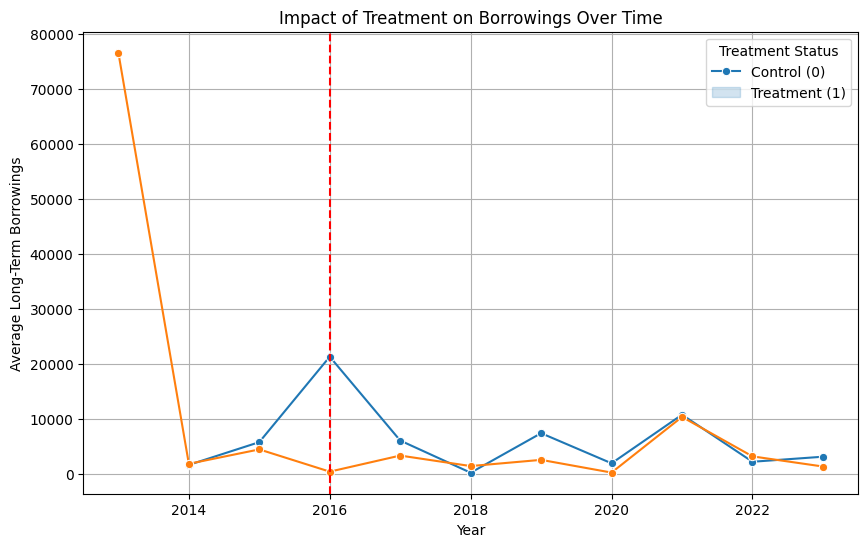

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by year and treatment status

df_grouped = fundementals_identity_related.groupby(['Year', 'treatment'])['sa_lt_borr_from_banks'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='Year', y='sa_lt_borr_from_banks', hue='treatment', marker='o')

# Labels and title
plt.axvline(x=2016, color='red', linestyle='--', label='Policy Change (2016)')
plt.xlabel('Year')
plt.ylabel('Average Long-Term Borrowings')
plt.title('Impact of Treatment on Borrowings Over Time')
plt.legend(title='Treatment Status', labels=['Control (0)', 'Treatment (1)'])
plt.grid()

plt.show()
